In [9]:
import pandas as pd
import tqdm.auto as tqdm

def read_csv_file(user_id, video_id):
    filepath = f'./Experiment_1/{user_id}/video_{video_id}.csv'
    df = pd.read_csv(filepath)
    df['video_id'] = video_id  # 添加video_id字段
    return df

data_with_labels = []

for user_id in range(1, 49):
    user_data = []
    for video_id in range(0, 9):
        df = read_csv_file(user_id, video_id)

        # 对数据进行预处理，例如计算每秒的坐标等
        # df = preprocess(df)
 
        # 添加标签（用户ID）
        df['user_id'] = user_id

        user_data.append(df)

    user_data_combined = pd.concat(user_data, ignore_index=True)
    data_with_labels.append(user_data_combined)

data_with_labels = pd.concat(data_with_labels, ignore_index=True)


In [10]:
from datetime import timedelta
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import to_categorical

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.nn.tanh(tf.linalg.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(tf.reduce_sum(q * x, axis=-1), axis=-1)
        return tf.reduce_sum(a[:, :, tf.newaxis] * x, axis=1)

def process_data(data, i):
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data['rounded_time'] = data['Timestamp'].dt.floor('100ms')

    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    print("Processing",i)
    for user_id, user_data in tqdm(data.groupby('user_id')):
        for video_id, video_data in user_data.groupby('video_id'):
            for second, second_data in video_data.groupby(video_data['rounded_time'].dt.floor('1s')):
                time_slices = []
                for _, chunk_data in second_data.groupby(pd.cut(second_data['Timestamp'], pd.date_range(second, second + timedelta(seconds=1), periods=11)), observed = True):
                    if not chunk_data.empty:
                        chunk_data = chunk_data[['UnitQuaternion.x', 'UnitQuaternion.y', 'UnitQuaternion.z', 'UnitQuaternion.w', 'HmdPosition.x', 'HmdPosition.y', 'HmdPosition.z']]
                        time_slices.append(chunk_data.mean().values)

                if len(time_slices) == 10:
                    if video_id == i:
                        test_data.append(time_slices)
                        test_labels.append(user_id)
                    else:
                        train_data.append(time_slices)
                        train_labels.append(user_id)

    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

# Load your data_with_labels dataframe here
# data_with_labels = pd.DataFrame(...)

# Define the path to save the models
model_path = './model_{}.tflite'

for i in range(9):
    train_data, train_labels, test_data, test_labels = process_data(data_with_labels, i)

    # Convert user IDs to integers
    unique_labels = np.unique(np.concatenate([train_labels, test_labels]))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    int_train_labels = np.array([label_map[label] for label in train_labels])
    int_test_labels = np.array([label_map[label] for label in test_labels])

    # Convert label data to one-hot encoding
    one_hot_train_labels = to_categorical(int_train_labels, num_classes=len(unique_labels))
    one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(unique_labels))

    # Train the model
    #with tf.device('/device:GPU:0'):
    # Define the model
    model = Sequential()
    model.add(Bidirectional(LSTM(128, input_shape=(10, 7), return_sequences=True)))
    model.add(AttentionLayer())
    model.add(Reshape((1, -1)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(len(unique_labels), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Reshape the training and testing data
    train_data = train_data.reshape(train_data.shape[0], 10, 7)
    test_data = test_data.reshape(test_data.shape[0], 10, 7)

    # Train the model
    batch_size = min(128, train_data.shape[0])
    model.fit(train_data, one_hot_train_labels, epochs=50, batch_size=batch_size, validation_data=(test_data, one_hot_test_labels))

    # Save the model to a file
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    tflite_model = converter.convert()

    # Save the model.
    with open(model_path.format(i), 'wb') as f:
        f.write(tflite_model)
    print(f"Model {i} saved to {model_path.format(i)}")


Processing 0


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 16:05:41.045193: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


917/917 [==============================] - ETA: 0s - loss: 1.6844 - accuracy: 0.4366

2023-10-14 16:06:05.405260: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


917/917 [==============================] - 28s 27ms/step - loss: 1.6844 - accuracy: 0.4366 - val_loss: 1.8483 - val_accuracy: 0.3925
Epoch 2/50
917/917 [==============================] - 24s 26ms/step - loss: 1.1063 - accuracy: 0.6126 - val_loss: 1.6161 - val_accuracy: 0.4714
Epoch 3/50
917/917 [==============================] - 24s 26ms/step - loss: 0.8796 - accuracy: 0.6991 - val_loss: 1.5740 - val_accuracy: 0.5505
Epoch 4/50
917/917 [==============================] - 25s 27ms/step - loss: 0.6847 - accuracy: 0.7729 - val_loss: 1.2791 - val_accuracy: 0.6314
Epoch 5/50
917/917 [==============================] - 24s 26ms/step - loss: 0.5514 - accuracy: 0.8161 - val_loss: 1.3330 - val_accuracy: 0.6715
Epoch 6/50
917/917 [==============================] - 24s 26ms/step - loss: 0.4739 - accuracy: 0.8416 - val_loss: 1.1474 - val_accuracy: 0.7067
Epoch 7/50
917/917 [==============================] - 24s 26ms/step - loss: 0.4189 - accuracy: 0.8601 - val_loss: 1.2650 - val_accuracy: 0.6839
Epo

2023-10-14 16:26:05.927082: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 16:26:05.927146: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 16:26:05.927280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 16:26:05.927292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 16:26:06.409315: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 16:26:06.409329: W tensorflow/compiler/m

Model 0 saved to ./model_0.tflite
Processing 1


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 16:32:59.666786: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


903/903 [==============================] - ETA: 0s - loss: 1.7034 - accuracy: 0.4317

2023-10-14 16:33:23.985312: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


903/903 [==============================] - 27s 28ms/step - loss: 1.7034 - accuracy: 0.4317 - val_loss: 1.4531 - val_accuracy: 0.4659
Epoch 2/50
903/903 [==============================] - 24s 26ms/step - loss: 1.1020 - accuracy: 0.6171 - val_loss: 1.2115 - val_accuracy: 0.5745
Epoch 3/50
903/903 [==============================] - 24s 26ms/step - loss: 0.8223 - accuracy: 0.7238 - val_loss: 1.0933 - val_accuracy: 0.6316
Epoch 4/50
903/903 [==============================] - 24s 26ms/step - loss: 0.6146 - accuracy: 0.7982 - val_loss: 0.9295 - val_accuracy: 0.6682
Epoch 5/50
903/903 [==============================] - 24s 26ms/step - loss: 0.4941 - accuracy: 0.8387 - val_loss: 0.8715 - val_accuracy: 0.6948
Epoch 6/50
903/903 [==============================] - 24s 26ms/step - loss: 0.4284 - accuracy: 0.8583 - val_loss: 0.8639 - val_accuracy: 0.7082
Epoch 7/50
903/903 [==============================] - 24s 26ms/step - loss: 0.3824 - accuracy: 0.8733 - val_loss: 0.7073 - val_accuracy: 0.7646
Epo

2023-10-14 16:53:41.048173: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 16:53:41.048240: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 16:53:41.048366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 16:53:41.048380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 16:53:41.192347: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 16:53:41.192363: W tensorflow/compiler/m

Model 1 saved to ./model_1.tflite
Processing 2


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 17:00:34.933521: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


869/869 [==============================] - ETA: 0s - loss: 1.6846 - accuracy: 0.4410

2023-10-14 17:00:58.896431: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


869/869 [==============================] - 28s 29ms/step - loss: 1.6846 - accuracy: 0.4410 - val_loss: 1.4424 - val_accuracy: 0.4827
Epoch 2/50
869/869 [==============================] - 24s 28ms/step - loss: 1.1182 - accuracy: 0.6122 - val_loss: 1.3189 - val_accuracy: 0.5455
Epoch 3/50
869/869 [==============================] - 24s 28ms/step - loss: 0.8685 - accuracy: 0.7071 - val_loss: 1.0828 - val_accuracy: 0.6281
Epoch 4/50
869/869 [==============================] - 25s 29ms/step - loss: 0.7183 - accuracy: 0.7603 - val_loss: 1.0348 - val_accuracy: 0.6524
Epoch 5/50
869/869 [==============================] - 25s 28ms/step - loss: 0.5812 - accuracy: 0.8056 - val_loss: 0.9715 - val_accuracy: 0.6776
Epoch 6/50
869/869 [==============================] - 25s 29ms/step - loss: 0.5044 - accuracy: 0.8326 - val_loss: 0.9304 - val_accuracy: 0.6909
Epoch 7/50
869/869 [==============================] - 28s 32ms/step - loss: 0.4404 - accuracy: 0.8536 - val_loss: 0.8835 - val_accuracy: 0.7211
Epo

2023-10-14 17:22:06.832462: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 17:22:06.832522: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 17:22:06.832673: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 17:22:06.832686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 17:22:06.982657: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 17:22:06.982671: W tensorflow/compiler/m

Model 2 saved to ./model_2.tflite
Processing 3


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 17:29:00.793152: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


914/914 [==============================] - ETA: 0s - loss: 1.7223 - accuracy: 0.4203

2023-10-14 17:29:27.474741: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


914/914 [==============================] - 30s 30ms/step - loss: 1.7223 - accuracy: 0.4203 - val_loss: 1.1213 - val_accuracy: 0.5901
Epoch 2/50
914/914 [==============================] - 26s 28ms/step - loss: 1.1320 - accuracy: 0.6048 - val_loss: 0.9729 - val_accuracy: 0.6606
Epoch 3/50
914/914 [==============================] - 25s 28ms/step - loss: 0.8682 - accuracy: 0.7032 - val_loss: 0.7268 - val_accuracy: 0.7740
Epoch 4/50
914/914 [==============================] - 25s 28ms/step - loss: 0.6990 - accuracy: 0.7657 - val_loss: 0.5639 - val_accuracy: 0.8279
Epoch 5/50
914/914 [==============================] - 25s 28ms/step - loss: 0.5621 - accuracy: 0.8134 - val_loss: 0.6024 - val_accuracy: 0.8113
Epoch 6/50
914/914 [==============================] - 25s 28ms/step - loss: 0.4905 - accuracy: 0.8367 - val_loss: 0.6209 - val_accuracy: 0.7914
Epoch 7/50
914/914 [==============================] - 25s 28ms/step - loss: 0.4475 - accuracy: 0.8503 - val_loss: 0.5459 - val_accuracy: 0.8179
Epo

2023-10-14 17:50:17.739003: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 17:50:17.739066: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 17:50:17.739186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 17:50:17.739197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 17:50:17.880126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 17:50:17.880137: W tensorflow/compiler/m

Model 3 saved to ./model_3.tflite
Processing 4


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 17:57:10.363369: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


902/902 [==============================] - ETA: 0s - loss: 1.7482 - accuracy: 0.4151

2023-10-14 17:57:36.999564: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


902/902 [==============================] - 30s 30ms/step - loss: 1.7482 - accuracy: 0.4151 - val_loss: 1.1518 - val_accuracy: 0.6007
Epoch 2/50
902/902 [==============================] - 25s 28ms/step - loss: 1.1565 - accuracy: 0.5941 - val_loss: 0.9188 - val_accuracy: 0.6927
Epoch 3/50
902/902 [==============================] - 25s 28ms/step - loss: 0.9106 - accuracy: 0.6889 - val_loss: 0.8152 - val_accuracy: 0.7141
Epoch 4/50
902/902 [==============================] - 25s 28ms/step - loss: 0.6953 - accuracy: 0.7675 - val_loss: 0.7245 - val_accuracy: 0.7493
Epoch 5/50
902/902 [==============================] - 25s 28ms/step - loss: 0.5708 - accuracy: 0.8096 - val_loss: 0.7198 - val_accuracy: 0.7647
Epoch 6/50
902/902 [==============================] - 25s 28ms/step - loss: 0.4811 - accuracy: 0.8398 - val_loss: 0.6995 - val_accuracy: 0.7769
Epoch 7/50
902/902 [==============================] - 25s 28ms/step - loss: 0.4357 - accuracy: 0.8539 - val_loss: 0.6381 - val_accuracy: 0.7765
Epo

2023-10-14 18:18:00.705663: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 18:18:00.705732: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 18:18:00.705865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 18:18:00.705881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 18:18:00.850219: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 18:18:00.850237: W tensorflow/compiler/m

Model 4 saved to ./model_4.tflite
Processing 5


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 18:24:50.095241: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


733/733 [==============================] - ETA: 0s - loss: 1.7000 - accuracy: 0.4361

2023-10-14 18:25:11.677902: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


733/733 [==============================] - 27s 34ms/step - loss: 1.7000 - accuracy: 0.4361 - val_loss: 1.4320 - val_accuracy: 0.5103
Epoch 2/50
733/733 [==============================] - 22s 31ms/step - loss: 1.0462 - accuracy: 0.6423 - val_loss: 1.0901 - val_accuracy: 0.6546
Epoch 3/50
733/733 [==============================] - 22s 31ms/step - loss: 0.7039 - accuracy: 0.7690 - val_loss: 0.8757 - val_accuracy: 0.7315
Epoch 4/50
733/733 [==============================] - 23s 31ms/step - loss: 0.5211 - accuracy: 0.8333 - val_loss: 0.7608 - val_accuracy: 0.7781
Epoch 5/50
733/733 [==============================] - 23s 31ms/step - loss: 0.4436 - accuracy: 0.8560 - val_loss: 0.7665 - val_accuracy: 0.7722
Epoch 6/50
733/733 [==============================] - 23s 31ms/step - loss: 0.3856 - accuracy: 0.8741 - val_loss: 0.7398 - val_accuracy: 0.7802
Epoch 7/50
733/733 [==============================] - 23s 31ms/step - loss: 0.3580 - accuracy: 0.8825 - val_loss: 0.7162 - val_accuracy: 0.7900
Epo

2023-10-14 18:44:12.650651: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 18:44:12.650722: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 18:44:12.650890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 18:44:12.650904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 18:44:12.801748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 18:44:12.801760: W tensorflow/compiler/m

Model 5 saved to ./model_5.tflite
Processing 6


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 18:51:04.925088: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


809/809 [==============================] - ETA: 0s - loss: 1.6500 - accuracy: 0.4403

2023-10-14 18:51:29.061877: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


809/809 [==============================] - 29s 32ms/step - loss: 1.6500 - accuracy: 0.4403 - val_loss: 2.0170 - val_accuracy: 0.3756
Epoch 2/50
809/809 [==============================] - 24s 30ms/step - loss: 1.1199 - accuracy: 0.6003 - val_loss: 1.7698 - val_accuracy: 0.4577
Epoch 3/50
809/809 [==============================] - 24s 30ms/step - loss: 0.9066 - accuracy: 0.6848 - val_loss: 1.6869 - val_accuracy: 0.5216
Epoch 4/50
809/809 [==============================] - 26s 32ms/step - loss: 0.6933 - accuracy: 0.7670 - val_loss: 1.5814 - val_accuracy: 0.5860
Epoch 5/50
809/809 [==============================] - 24s 30ms/step - loss: 0.5662 - accuracy: 0.8098 - val_loss: 1.4766 - val_accuracy: 0.6113
Epoch 6/50
809/809 [==============================] - 24s 30ms/step - loss: 0.4757 - accuracy: 0.8409 - val_loss: 1.4292 - val_accuracy: 0.6417
Epoch 7/50
809/809 [==============================] - 24s 30ms/step - loss: 0.4098 - accuracy: 0.8622 - val_loss: 1.5592 - val_accuracy: 0.6280
Epo

2023-10-14 19:11:22.490938: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 19:11:22.491012: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 19:11:22.491145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 19:11:22.491156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 19:11:22.632938: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 19:11:22.632951: W tensorflow/compiler/m

Model 6 saved to ./model_6.tflite
Processing 7


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 19:18:11.893502: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


916/916 [==============================] - ETA: 0s - loss: 1.6945 - accuracy: 0.4321

2023-10-14 19:18:39.031295: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


916/916 [==============================] - 30s 30ms/step - loss: 1.6945 - accuracy: 0.4321 - val_loss: 1.5856 - val_accuracy: 0.4958
Epoch 2/50
916/916 [==============================] - 25s 28ms/step - loss: 1.0965 - accuracy: 0.6174 - val_loss: 1.4002 - val_accuracy: 0.5640
Epoch 3/50
916/916 [==============================] - 27s 30ms/step - loss: 0.8048 - accuracy: 0.7284 - val_loss: 1.1634 - val_accuracy: 0.6298
Epoch 4/50
916/916 [==============================] - 26s 29ms/step - loss: 0.6094 - accuracy: 0.7972 - val_loss: 0.9361 - val_accuracy: 0.6997
Epoch 5/50
916/916 [==============================] - 26s 28ms/step - loss: 0.5162 - accuracy: 0.8284 - val_loss: 0.8846 - val_accuracy: 0.7168
Epoch 6/50
916/916 [==============================] - 25s 28ms/step - loss: 0.4436 - accuracy: 0.8514 - val_loss: 0.9384 - val_accuracy: 0.7059
Epoch 7/50
916/916 [==============================] - 26s 29ms/step - loss: 0.3936 - accuracy: 0.8684 - val_loss: 0.8284 - val_accuracy: 0.7437
Epo

2023-10-14 19:40:15.123898: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 19:40:15.123973: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 19:40:15.124095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 19:40:15.124107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 19:40:15.261800: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 19:40:15.261811: W tensorflow/compiler/m

Model 7 saved to ./model_7.tflite
Processing 8


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/50


2023-10-14 19:47:10.982929: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


867/867 [==============================] - ETA: 0s - loss: 1.6682 - accuracy: 0.4433

2023-10-14 19:47:39.146788: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


867/867 [==============================] - 33s 35ms/step - loss: 1.6682 - accuracy: 0.4433 - val_loss: 1.8655 - val_accuracy: 0.3991
Epoch 2/50
867/867 [==============================] - 27s 32ms/step - loss: 1.0627 - accuracy: 0.6304 - val_loss: 1.7467 - val_accuracy: 0.4768
Epoch 3/50
867/867 [==============================] - 27s 31ms/step - loss: 0.8154 - accuracy: 0.7214 - val_loss: 1.6444 - val_accuracy: 0.5293
Epoch 4/50
867/867 [==============================] - 27s 31ms/step - loss: 0.6404 - accuracy: 0.7854 - val_loss: 1.5000 - val_accuracy: 0.5790
Epoch 5/50
867/867 [==============================] - 27s 31ms/step - loss: 0.5460 - accuracy: 0.8173 - val_loss: 1.4784 - val_accuracy: 0.5739
Epoch 6/50
867/867 [==============================] - 27s 32ms/step - loss: 0.4591 - accuracy: 0.8462 - val_loss: 1.4414 - val_accuracy: 0.5976
Epoch 7/50
867/867 [==============================] - 28s 32ms/step - loss: 0.4113 - accuracy: 0.8622 - val_loss: 1.6404 - val_accuracy: 0.5554
Epo

2023-10-14 20:09:57.153125: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 20:09:57.153190: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 20:09:57.153313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 20:09:57.153322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 20:09:57.298239: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 20:09:57.298253: W tensorflow/compiler/m

Model 8 saved to ./model_8.tflite


In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from keras.utils import to_categorical
import tensorflow as tf
# 将用户ID转换为从0开始的整数
unique_labels = np.unique(np.concatenate([train_labels, test_labels]))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
int_train_labels = np.array([label_map[label] for label in train_labels])
int_test_labels = np.array([label_map[label] for label in test_labels])

# 将标签数据转换为one-hot编码
one_hot_train_labels = to_categorical(int_train_labels, num_classes=len(unique_labels))
one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(unique_labels))

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.nn.tanh(tf.linalg.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(tf.reduce_sum(q * x, axis=-1), axis=-1)
        return tf.reduce_sum(a[:, :, tf.newaxis] * x, axis=1)



In [14]:
#with tf.device('/device:GPU:0'):
# 定义模型
model = Sequential()
model.add(LSTM(128, input_shape=(10, 7), return_sequences=True))
model.add(AttentionLayer())
model.add(Reshape((1, -1)))
model.add(LSTM(64))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 重塑训练和测试数据
train_data = train_data.reshape(train_data.shape[0], 10, 7)
test_data = test_data.reshape(test_data.shape[0], 10, 7)

# 训练模型
batch_size = min(128, train_data.shape[0])
model.fit(train_data, one_hot_train_labels, epochs=50, batch_size=batch_size, validation_data=(test_data, one_hot_test_labels))

Epoch 1/50


2023-10-14 20:13:59.266714: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


555/555 [==============================] - ETA: 0s - loss: 1.9434 - accuracy: 0.3876

2023-10-14 20:14:12.569159: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


555/555 [==============================] - 17s 27ms/step - loss: 1.9434 - accuracy: 0.3876 - val_loss: 1.5222 - val_accuracy: 0.4648
Epoch 2/50
555/555 [==============================] - 13s 23ms/step - loss: 1.3566 - accuracy: 0.5235 - val_loss: 1.2959 - val_accuracy: 0.5486
Epoch 3/50
555/555 [==============================] - 13s 23ms/step - loss: 1.1968 - accuracy: 0.5837 - val_loss: 1.1440 - val_accuracy: 0.6050
Epoch 4/50
555/555 [==============================] - 12s 22ms/step - loss: 1.0939 - accuracy: 0.6193 - val_loss: 1.0701 - val_accuracy: 0.6226
Epoch 5/50
555/555 [==============================] - 12s 23ms/step - loss: 0.9989 - accuracy: 0.6536 - val_loss: 0.9543 - val_accuracy: 0.6780
Epoch 6/50
555/555 [==============================] - 13s 23ms/step - loss: 0.9138 - accuracy: 0.6879 - val_loss: 0.9071 - val_accuracy: 0.6908
Epoch 7/50
555/555 [==============================] - 12s 22ms/step - loss: 0.8259 - accuracy: 0.7219 - val_loss: 0.8197 - val_accuracy: 0.7288
Epo

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the model to disk
with open('modelB.tflite', 'wb') as f:
    f.write(tflite_model)

2023-10-14 20:24:53.238560: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-10-14 20:24:53.238626: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-14 20:24:53.238759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 20:24:53.238775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-14 20:24:54.054586: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-14 20:24:54.054600: W tensorflow/compiler/m

In [19]:
print(train_data[1])

[[-0.07188889  0.92844444 -0.00966667  0.36477778 -0.13188889  1.209
  -0.344     ]
 [-0.06922222  0.92877778 -0.01        0.36377778 -0.13088889  1.209
  -0.34388889]
 [-0.06722222  0.92711111 -0.01133333  0.36855556 -0.13        1.209
  -0.343     ]
 [-0.06544444  0.926      -0.01477778  0.37144444 -0.12977778  1.208
  -0.343     ]
 [-0.065       0.92622222 -0.016       0.37044444 -0.13        1.208
  -0.343     ]
 [-0.06611111  0.92655556 -0.01677778  0.37       -0.131       1.208
  -0.343     ]
 [-0.06644444  0.926      -0.015       0.37066667 -0.131       1.20811111
  -0.343     ]
 [-0.06655556  0.92577778 -0.014       0.37233333 -0.131       1.20866667
  -0.34244444]
 [-0.06633333  0.926      -0.014       0.37144444 -0.131       1.20822222
  -0.342     ]
 [-0.066       0.926      -0.014       0.371      -0.131       1.208
  -0.341125  ]]


Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

2023-10-14 20:32:12.961168: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6/6 [==============================] - 1s 71ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 65ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 14ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 8ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 9ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 1, average accuracy: 0.90
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 2, average accuracy: 0.90
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Video ID: 0, Window size: 3, average accuracy: 0.92
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 4, average accuracy: 0.92
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 0, Window size: 5, average accuracy: 0.93
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Video ID: 0, Window size: 6, average accuracy: 0.93
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 50ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 50ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 46ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 7ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 7ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 7ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 1, average accuracy: 0.94
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 7ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 2, average accuracy: 0.93
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 3, average accuracy: 0.96
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 4, average accuracy: 0.96
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 5, average accuracy: 0.97
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 1, Window size: 6, average accuracy: 0.97
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 12ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 1, average accuracy: 0.94
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 2, average accuracy: 0.94
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 3, average accuracy: 0.95
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 4, average accuracy: 0.96
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 2, Window size: 5, average accuracy: 0.97
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Video ID: 2, Window size: 6, average accuracy: 0.97
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 59ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 18ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 8ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 1, average accuracy: 0.96
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Video ID: 3, Window size: 2, average accuracy: 0.96
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 3, average accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 4, average accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 5, average accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 3, Window size: 6, average accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 50ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 8ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 7ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 6ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Video ID: 4, Window size: 1, average accuracy: 0.94
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 2, average accuracy: 0.94
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 3, average accuracy: 0.96
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 4, average accuracy: 0.96
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 5, average accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step
Video ID: 4, Window size: 6, average accuracy: 0.97
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 18ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 1, average accuracy: 0.93
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 2, average accuracy: 0.93
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 3, average accuracy: 0.95
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 4, average accuracy: 0.95
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 5, average accuracy: 0.96
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 5ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

21/21 [==============================] - 0s 4ms/step
Video ID: 5, Window size: 6, average accuracy: 0.96
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 1, average accuracy: 0.94
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 2, average accuracy: 0.95
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Video ID: 6, Window size: 3, average accuracy: 0.96
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 4, average accuracy: 0.96
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Video ID: 6, Window size: 5, average accuracy: 0.97
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 5ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

15/15 [==============================] - 0s 4ms/step
Video ID: 6, Window size: 6, average accuracy: 0.97
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 55ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 51ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 52ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 1, average accuracy: 0.91
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 9ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 2, average accuracy: 0.92
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 3, average accuracy: 0.93
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 4, average accuracy: 0.95
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 7ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 5, average accuracy: 0.95
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 5ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 6ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

6/6 [==============================] - 0s 4ms/step
Video ID: 7, Window size: 6, average accuracy: 0.95
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 1, average accuracy: 0.65
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Video ID: 8, Window size: 2, average accuracy: 0.65
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 6ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Video ID: 8, Window size: 3, average accuracy: 0.66
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 4, average accuracy: 0.67
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 5, average accuracy: 0.68
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
Video ID: 8, Window size: 6, average accuracy: 0.67


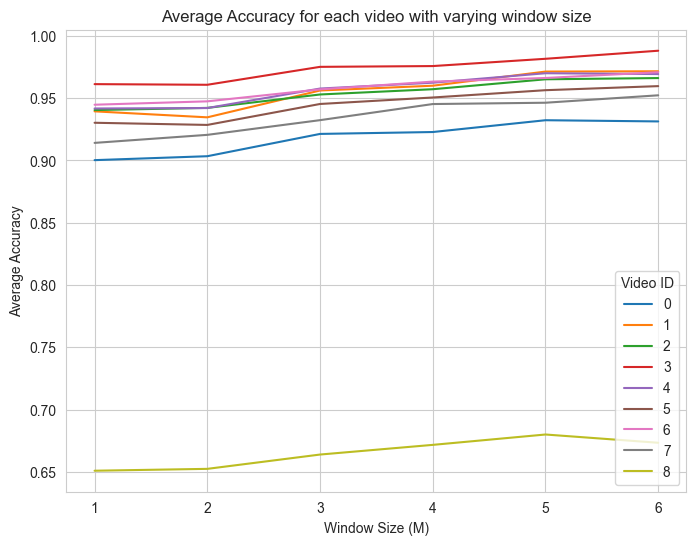

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
import seaborn as sns
from keras.utils import to_categorical
sns.set_style("whitegrid")

def majority_vote(predictions, window_size):
    vote_results = []
    for i in range(0, len(predictions) - window_size + 1, window_size):
        votes = predictions[i:i+window_size]
        vote_result = np.argmax(np.bincount(votes))
        vote_results.append(vote_result)
    return vote_results

def compute_accuracy_with_window(model, data_with_labels, label_map, window_sizes):
    acc_results = []

    for video_id in range(9):
        for window_size in window_sizes:
            accuracy_per_window = []
            for user_id in range(1, 49):
                # 从原始数据中筛选出user_id对应的测试集和video_id的数据
                test_data = data_with_labels[(data_with_labels['user_id'] == user_id) & (data_with_labels['video_id'] == video_id)]

                if test_data.empty:
                    continue

                # 处理数据并获取对应的标签
                train_data, train_labels, test_data, test_labels = process_data(test_data, video_id)
                int_test_labels = np.array([label_map[label] for label in test_labels])
                one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(label_map))

                # 重塑测试数据
                test_data = test_data.reshape(test_data.shape[0], 10, 7)

                # 获取模型预测
                predictions = model.predict(test_data)
                predictions = np.argmax(predictions, axis=1)

                # 应用滑动窗口和多数投票
                vote_results = majority_vote(predictions, window_size)

                # 计算滑动窗口和多数投票后的准确率
                correct = np.sum(vote_results == int_test_labels[:len(vote_results)])
                accuracy = correct / len(vote_results)
                accuracy_per_window.append(accuracy)

            # 计算当前窗口大小下所有用户的平均准确率
            acc_results.append((video_id, window_size, np.mean(accuracy_per_window)))
            print('Video ID: %d, Window size: %d, average accuracy: %.2f' % (video_id, window_size, np.mean(accuracy_per_window)))

    return acc_results

# 设置窗口大小范围
window_sizes = list(range(1, 7, 1))

# 计算各个窗口大小下的准确率
accuracy_results = compute_accuracy_with_window(model, data_with_labels, label_map, window_sizes)

# 转换成pandas DataFrame格式以便绘图
accuracy_df = pd.DataFrame(accuracy_results, columns=['video_id', 'window_size', 'accuracy'])

# 绘制折线图
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='window_size', y='accuracy', hue='video_id', palette='tab10')
plt.xlabel('Window Size (M)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for each video with varying window size')
plt.xticks(window_sizes)
plt.grid(True)
plt.legend(title='Video ID', loc='lower right')
plt.show()


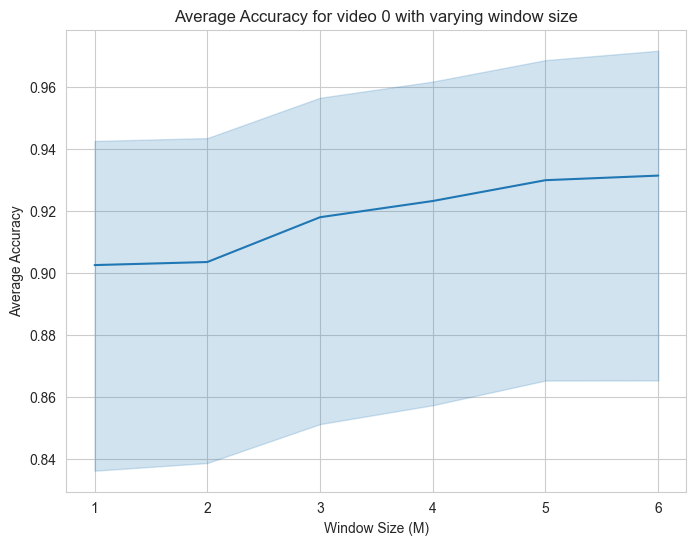

In [24]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='window_size', y='accuracy')
plt.xlabel('Window Size (M)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for video 0 with varying window size')
plt.xticks(window_sizes)
plt.grid(True)
plt.show()


Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 0, accuracy: 0.85
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 1, accuracy: 0.81
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 2, accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 4, accuracy: 0.86
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 5, accuracy: 0.99
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 6, accuracy: 0.98
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 7, accuracy: 0.87
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 1, video_id: 8, accuracy: 0.79
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 0, accuracy: 0.96
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 1, accuracy: 0.97
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 2, accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 4, accuracy: 0.88
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 5, accuracy: 0.97
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 6, accuracy: 0.96
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 2, video_id: 8, accuracy: 0.47
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 2, accuracy: 0.99
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 3, accuracy: 1.00
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 4, accuracy: 0.97
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 5, accuracy: 0.95
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 6, accuracy: 0.87
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 7, accuracy: 0.86
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 3, video_id: 8, accuracy: 0.06
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 0, accuracy: 0.83
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 1, accuracy: 0.96
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 2, accuracy: 0.99
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 3, accuracy: 0.82
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 4, accuracy: 0.81
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 5, accuracy: 0.95
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 6, accuracy: 0.90
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 7, accuracy: 0.80
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 4, video_id: 8, accuracy: 0.90
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 0, accuracy: 0.97
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 2, accuracy: 0.95
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 3, accuracy: 1.00
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 4, accuracy: 0.99
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 5, accuracy: 0.98
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 6, accuracy: 0.89
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 5, video_id: 8, accuracy: 0.68
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 0, accuracy: 0.87
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 2, accuracy: 0.96
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 4, accuracy: 0.99
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 5, accuracy: 0.95
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 6, accuracy: 0.97
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 7, accuracy: 1.00
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 6, video_id: 8, accuracy: 0.56
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 0, accuracy: 0.90
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 1, accuracy: 0.92
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 2, accuracy: 0.96
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 3, accuracy: 0.95
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 4, accuracy: 0.94
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 5, accuracy: 0.97
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 6, accuracy: 0.96
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 7, accuracy: 0.93
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 7, video_id: 8, accuracy: 0.81
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 0, accuracy: 0.77
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 1, accuracy: 0.96
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 2, accuracy: 0.69
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 3, accuracy: 0.88
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 4, accuracy: 0.91
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 5, accuracy: 0.81
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 6, accuracy: 0.84
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 7, accuracy: 0.78
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 8, video_id: 8, accuracy: 0.59
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 1, accuracy: 0.84
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 2, accuracy: 0.92
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 3, accuracy: 0.95
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 4, accuracy: 0.97
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 5, accuracy: 0.91
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 7, accuracy: 1.00
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 9, video_id: 8, accuracy: 0.83
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 0, accuracy: 0.99
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 2, accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 5, accuracy: 0.85
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 6, accuracy: 0.91
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 10, video_id: 8, accuracy: 0.81
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 0, accuracy: 0.99
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 2, accuracy: 1.00
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 3, accuracy: 1.00
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 5, accuracy: 0.99
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 6, accuracy: 0.97
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 7, accuracy: 0.96
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 11, video_id: 8, accuracy: 0.86
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 0, accuracy: 0.92
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 1, accuracy: 0.96
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 2, accuracy: 0.94
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 3, accuracy: 0.91
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 4, accuracy: 0.92
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 5, accuracy: 0.86
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 6, accuracy: 0.97
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 7, accuracy: 0.89
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 12, video_id: 8, accuracy: 0.42
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 0, accuracy: 0.88
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 1, accuracy: 0.89
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 2, accuracy: 0.83
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 3, accuracy: 0.90
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 4, accuracy: 0.91
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 5, accuracy: 0.90
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 6, accuracy: 0.86
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 7, accuracy: 0.77
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 13, video_id: 8, accuracy: 0.42
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 0, accuracy: 0.66
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 1, accuracy: 0.90
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 2, accuracy: 0.87
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 4, accuracy: 0.81
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 5, accuracy: 0.68
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 6, accuracy: 0.91
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 7, accuracy: 0.72
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 14, video_id: 8, accuracy: 0.61
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 0, accuracy: 0.87
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 1, accuracy: 0.90
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 2, accuracy: 0.95
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 3, accuracy: 0.95
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 5, accuracy: 0.98
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 6, accuracy: 0.98
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 7, accuracy: 0.84
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 15, video_id: 8, accuracy: 0.24
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 0, accuracy: 0.85
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 1, accuracy: 0.84
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 2, accuracy: 0.85
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 3, accuracy: 0.84
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 4, accuracy: 0.93
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 5, accuracy: 0.94
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 6, accuracy: 0.99
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 7, accuracy: 0.95
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 16, video_id: 8, accuracy: 0.73
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 0, accuracy: 0.54
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 1, accuracy: 0.75
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 2, accuracy: 0.96
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 3, accuracy: 0.90
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 4, accuracy: 0.84
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 5, accuracy: 0.96
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 6, accuracy: 0.95
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 7, accuracy: 0.90
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 17, video_id: 8, accuracy: 0.73
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 2, accuracy: 1.00
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 3, accuracy: 1.00
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 5, accuracy: 1.00
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 7, accuracy: 1.00
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 18, video_id: 8, accuracy: 0.50
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 2, accuracy: 0.95
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 4, accuracy: 0.98
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 5, accuracy: 1.00
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 6, accuracy: 0.98
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 7, accuracy: 0.95
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 19, video_id: 8, accuracy: 0.75
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 0, accuracy: 0.99
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 2, accuracy: 0.99
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 4, accuracy: 0.95
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 5, accuracy: 0.96
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 20, video_id: 8, accuracy: 0.99
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 0, accuracy: 0.98
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 2, accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 4, accuracy: 0.96
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 5, accuracy: 0.92
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 6, accuracy: 0.92
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 21, video_id: 8, accuracy: 0.28
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 0, accuracy: 0.98
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 2, accuracy: 0.97
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 3, accuracy: 0.94
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 4, accuracy: 0.92
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 5, accuracy: 0.94
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 6, accuracy: 0.87
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 7, accuracy: 0.85
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 22, video_id: 8, accuracy: 0.06
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 0, accuracy: 0.97
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 2, accuracy: 0.95
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 4, accuracy: 0.75
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 5, accuracy: 0.93
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 6, accuracy: 0.97
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 7, accuracy: 0.96
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 23, video_id: 8, accuracy: 0.96
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 0, accuracy: 0.80
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 1, accuracy: 0.79
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 2, accuracy: 1.00
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 3, accuracy: 0.91
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 4, accuracy: 0.85
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 5, accuracy: 0.74
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 6, accuracy: 0.80
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 7, accuracy: 0.53
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 24, video_id: 8, accuracy: 0.15
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 0, accuracy: 0.91
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 1, accuracy: 0.95
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 2, accuracy: 0.93
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 4, accuracy: 0.96
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 5, accuracy: 0.96
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 6, accuracy: 0.94
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 7, accuracy: 0.94
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 25, video_id: 8, accuracy: 0.88
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 0, accuracy: 0.30
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 1, accuracy: 0.83
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 2, accuracy: 0.84
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 4, accuracy: 0.93
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 5, accuracy: 0.99
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 6, accuracy: 0.99
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 7, accuracy: 0.95
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 26, video_id: 8, accuracy: 0.93
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 0, accuracy: 0.98
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 2, accuracy: 0.97
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 4, accuracy: 0.94
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 5, accuracy: 0.98
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 6, accuracy: 0.99
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 27, video_id: 8, accuracy: 0.05
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 0, accuracy: 0.91
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 1, accuracy: 0.94
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 2, accuracy: 0.80
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 4, accuracy: 0.96
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 5, accuracy: 0.94
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 28, video_id: 8, accuracy: 0.74
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 2, accuracy: 1.00
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 3, accuracy: 1.00
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 5, accuracy: 0.99
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 29, video_id: 8, accuracy: 0.99
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 2, accuracy: 0.99
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 3, accuracy: 1.00
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 5, accuracy: 0.97
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 6, accuracy: 0.93
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 7, accuracy: 0.60
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 30, video_id: 8, accuracy: 0.26
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 0, accuracy: 0.99
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 2, accuracy: 0.94
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 4, accuracy: 0.98
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 5, accuracy: 0.96
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 6, accuracy: 0.99
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 31, video_id: 8, accuracy: 0.97
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 0, accuracy: 0.79
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 1, accuracy: 0.84
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 2, accuracy: 0.96
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 5, accuracy: 0.99
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 7, accuracy: 1.00
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 32, video_id: 8, accuracy: 0.93
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 0, accuracy: 0.98
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 1, accuracy: 0.96
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 2, accuracy: 0.98
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 4, accuracy: 0.97
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 5, accuracy: 0.97
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 6, accuracy: 0.97
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 33, video_id: 8, accuracy: 0.96
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 0, accuracy: 0.75
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 1, accuracy: 0.96
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 2, accuracy: 0.97
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 4, accuracy: 0.99
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 5, accuracy: 1.00
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 34, video_id: 8, accuracy: 0.98
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 0, accuracy: 0.93
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 1, accuracy: 0.88
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 2, accuracy: 0.90
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 4, accuracy: 0.93
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 5, accuracy: 0.81
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 6, accuracy: 0.95
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 7, accuracy: 0.97
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 35, video_id: 8, accuracy: 0.76
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 0, accuracy: 0.85
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 2, accuracy: 0.89
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 3, accuracy: 0.92
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 4, accuracy: 0.96
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 5, accuracy: 0.74
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 6, accuracy: 0.70
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 7, accuracy: 0.84
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 36, video_id: 8, accuracy: 0.29
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 0, accuracy: 0.95
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 2, accuracy: 0.94
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 3, accuracy: 0.95
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 4, accuracy: 0.92
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 5, accuracy: 0.87
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 6, accuracy: 0.87
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 7, accuracy: 0.77
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 37, video_id: 8, accuracy: 0.15
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 0, accuracy: 0.81
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 1, accuracy: 0.95
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 2, accuracy: 0.92
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 3, accuracy: 0.91
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 4, accuracy: 0.96
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 5, accuracy: 0.84
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 6, accuracy: 0.91
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 7, accuracy: 0.85
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 38, video_id: 8, accuracy: 0.74
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 0, accuracy: 0.96
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 1, accuracy: 0.97
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 2, accuracy: 0.94
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 3, accuracy: 0.95
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 4, accuracy: 0.90
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 5, accuracy: 0.97
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 6, accuracy: 0.99
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 39, video_id: 8, accuracy: 0.77
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 0, accuracy: 0.99
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 2, accuracy: 0.99
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 4, accuracy: 0.98
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 5, accuracy: 0.98
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 6, accuracy: 0.99
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 40, video_id: 8, accuracy: 0.85
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 0, accuracy: 0.87
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 1, accuracy: 0.99
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 2, accuracy: 0.97
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 4, accuracy: 0.98
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 5, accuracy: 0.95
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 6, accuracy: 0.96
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 41, video_id: 8, accuracy: 0.69
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 0, accuracy: 0.97
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 2, accuracy: 0.97
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 4, accuracy: 0.95
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 5, accuracy: 0.90
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 6, accuracy: 0.90
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 7, accuracy: 0.90
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 42, video_id: 8, accuracy: 0.63
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 0, accuracy: 0.89
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 1, accuracy: 0.71
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 2, accuracy: 0.73
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 3, accuracy: 0.95
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 4, accuracy: 0.85
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 5, accuracy: 0.80
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 6, accuracy: 0.84
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 7, accuracy: 0.86
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 43, video_id: 8, accuracy: 0.17
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 2, accuracy: 1.00
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 3, accuracy: 1.00
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 5, accuracy: 1.00
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 7, accuracy: 1.00
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 44, video_id: 8, accuracy: 0.99
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 0, accuracy: 0.96
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 1, accuracy: 1.00
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 2, accuracy: 1.00
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 3, accuracy: 0.99
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 5, accuracy: 1.00
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 7, accuracy: 0.99
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 45, video_id: 8, accuracy: 0.99
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 0, accuracy: 0.88
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 1, accuracy: 0.92
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 2, accuracy: 0.96
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 3, accuracy: 0.98
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 4, accuracy: 0.96
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 5, accuracy: 1.00
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 7, accuracy: 0.96
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 46, video_id: 8, accuracy: 0.86
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 0, accuracy: 0.98
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 1, accuracy: 0.98
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 2, accuracy: 0.95
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 3, accuracy: 0.97
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 4, accuracy: 0.98
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 5, accuracy: 1.00
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 6, accuracy: 1.00
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 7, accuracy: 0.98
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 47, video_id: 8, accuracy: 0.92
Processing 0


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 0, accuracy: 1.00
Processing 1


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 1, accuracy: 0.99
Processing 2


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 2, accuracy: 0.99
Processing 3


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 3, accuracy: 0.96
Processing 4


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 4, accuracy: 1.00
Processing 5


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 5, accuracy: 0.91
Processing 6


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 6, accuracy: 0.98
Processing 7


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 7, accuracy: 0.86
Processing 8


/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])
/var/folders/ch/b__qjpx978x5jrjnqmw6gpx00000gr/T/ipykernel_9846/3666484731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_time'] = data['Timestamp'].dt.floor('100ms')


  0%|          | 0/1 [00:00<?, ?it/s]

user_id: 48, video_id: 8, accuracy: 0.54


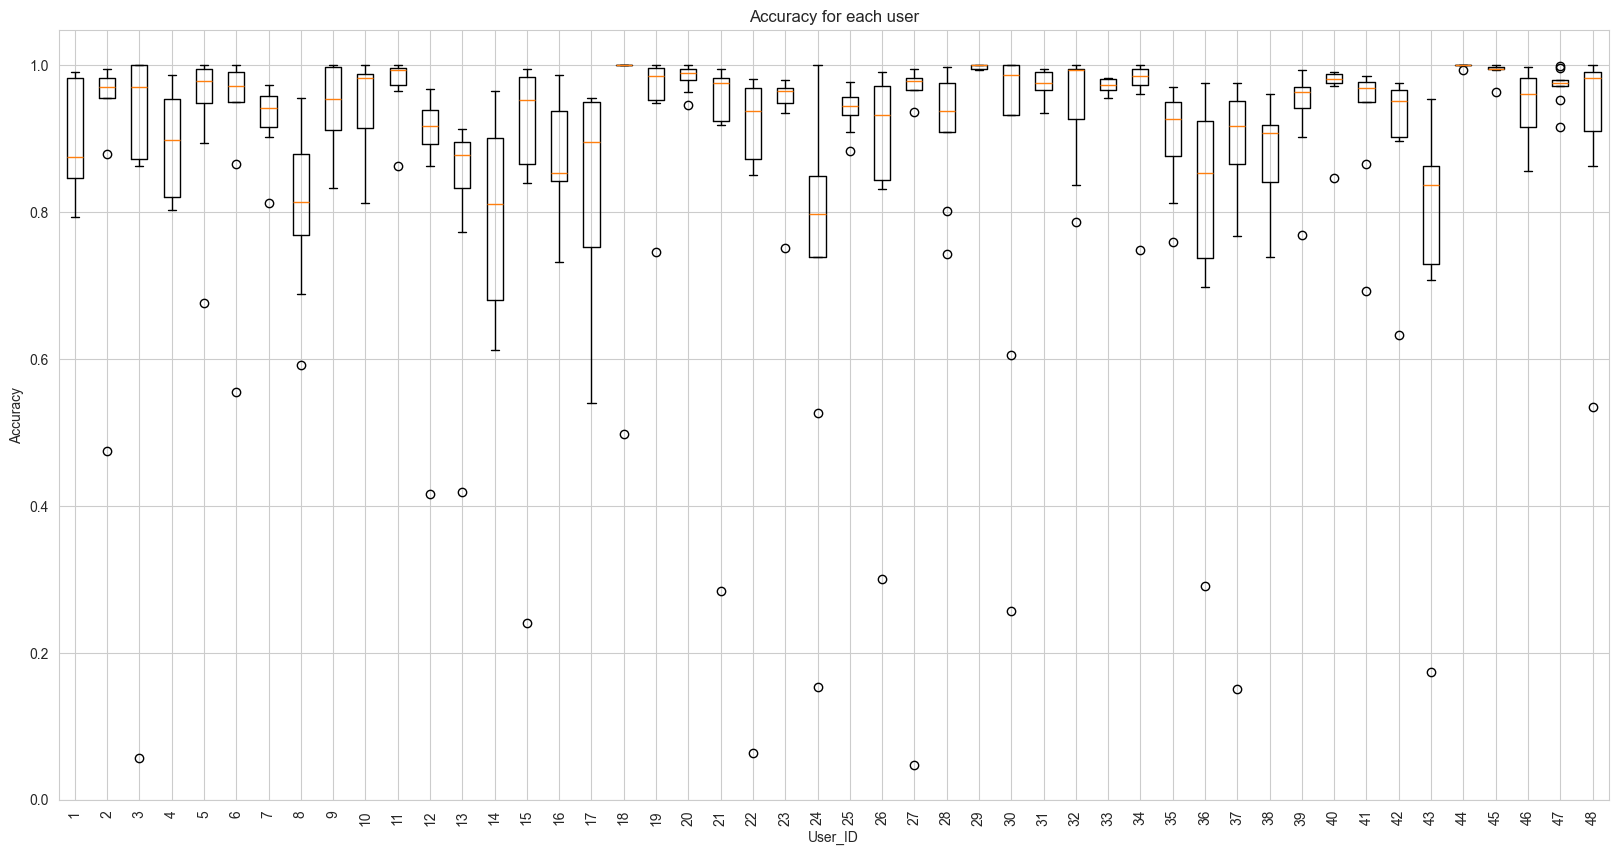

In [26]:
def compute_accuracy_per_user(model, data_with_labels, unique_labels, label_map):
    user_acc_results = {}

    for user_id in range(1, 49): # assume user_id from 1 to 48
        acc_results = []

        for video_id in range(0, 9):
            # 从原始数据中筛选出video_id和user_id对应的测试集
            test_data = data_with_labels[(data_with_labels['video_id'] == video_id) & (data_with_labels['user_id'] == user_id)]

            # 如果测试数据为空，跳过此轮循环
            if test_data.empty:
                continue

            # 处理数据并获取对应的标签
            train_data, train_labels, test_data, test_labels = process_data(test_data, video_id)
            int_test_labels = np.array([label_map[label] for label in test_labels])
            one_hot_test_labels = to_categorical(int_test_labels, num_classes=len(unique_labels))

            # 重塑测试数据
            test_data = test_data.reshape(test_data.shape[0], 10, 7)

            try:
                # 计算准确率
                loss, accuracy = model.evaluate(test_data, one_hot_test_labels, batch_size=len(test_data), verbose=0)
            except ValueError as e:
                print(f"Skipping evaluation for user_id: {user_id}, video_id: {video_id}. Evaluation returned: {e}")
                continue

            acc_results.append(accuracy)
            print('user_id: %d, video_id: %d, accuracy: %.2f' % (user_id, video_id, accuracy))

        # 若对于某个用户没有任何准确度数据（可能该用户没有对应的数据），则不添加到最终的结果中
        if acc_results:
            user_acc_results[user_id] = acc_results

    return user_acc_results

# 计算各个测试集的准确率
user_accuracy_results = compute_accuracy_per_user(model, data_with_labels, unique_labels, label_map)

# 创建箱形图
plt.figure(figsize=(20, 10)) # You might need to adjust the figure size
plt.boxplot([user_accuracy_results[user_id] for user_id in sorted(user_accuracy_results.keys())], labels=sorted(user_accuracy_results.keys()))
plt.xlabel('User_ID')
plt.ylabel('Accuracy')
plt.title('Accuracy for each user')
plt.xticks(rotation=90)  # It might be necessary to rotate the x-tick labels for better visualization
plt.show()


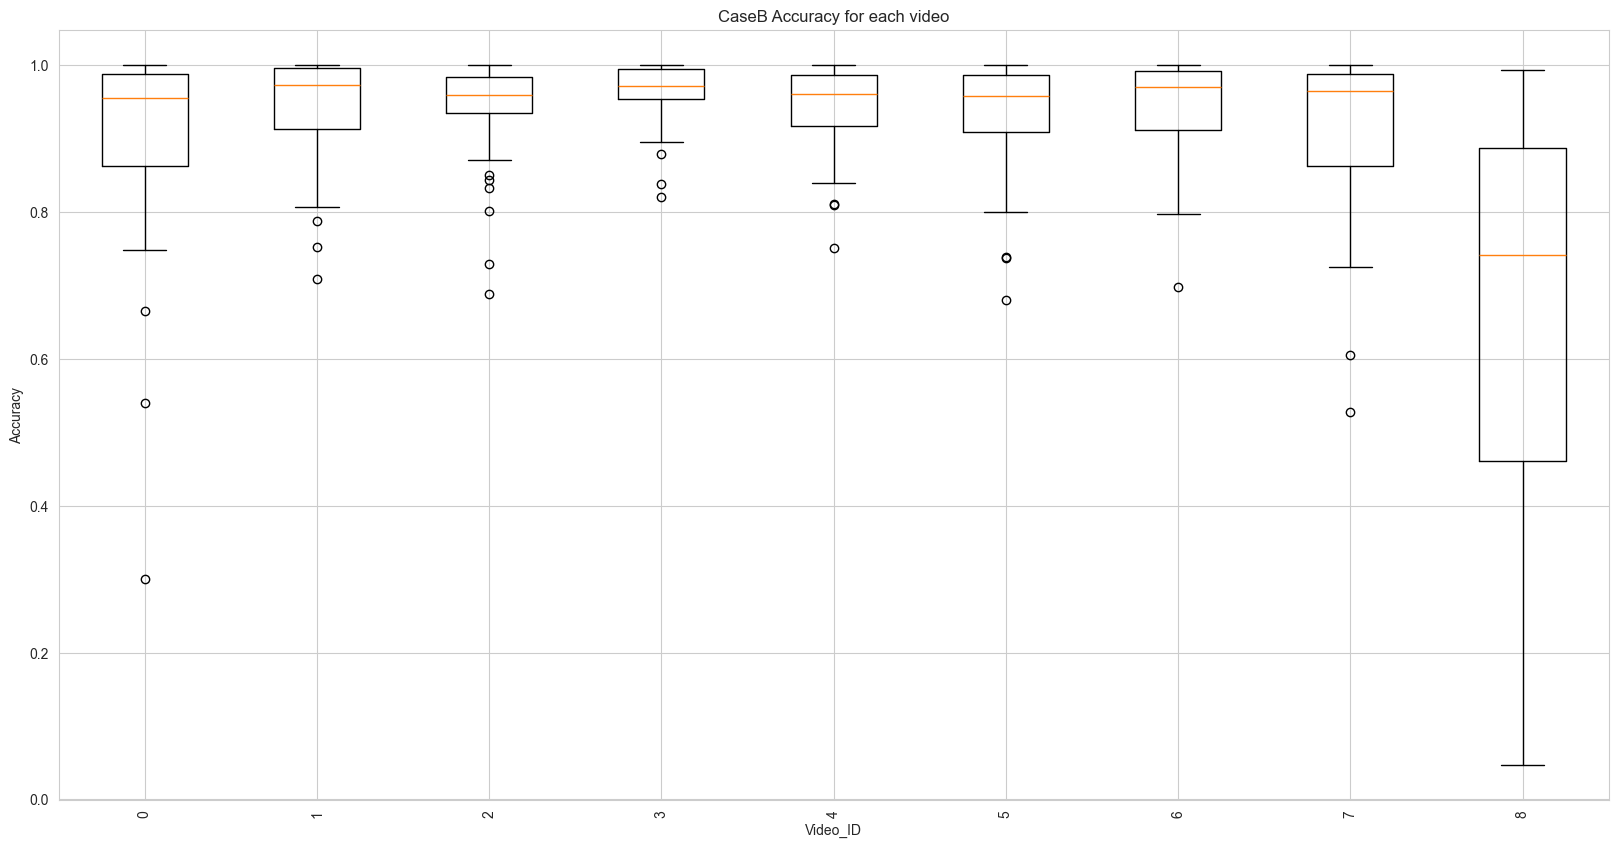

In [27]:
def reorganize_accuracy_by_video(user_accuracy_results):
    video_acc_results = {i: [] for i in range(0, 9)}
    for user_id, acc_list in user_accuracy_results.items():
        for video_id, accuracy in enumerate(acc_list):
            video_acc_results[video_id].append(accuracy)
    return video_acc_results

video_accuracy_results = reorganize_accuracy_by_video(user_accuracy_results)

plt.figure(figsize=(20, 10)) # You might need to adjust the figure size
plt.boxplot([video_accuracy_results[video_id] for video_id in sorted(video_accuracy_results.keys())], labels=sorted(video_accuracy_results.keys()))
plt.xlabel('Video_ID')
plt.ylabel('Accuracy')
plt.title('CaseB Accuracy for each video')
plt.xticks(rotation=90)  # It might be necessary to rotate the x-tick labels for better visualization
plt.show()


In [31]:
plt.close('all')